# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

try:
    from xgboost import XGBRegressor
    xgb_available = True
except:
    xgb_available = False

# 2. Chargement des données

In [2]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

y = np.log1p(train["SalePrice"])

train.drop(columns=["Id", "SalePrice"], inplace=True)
test_ids = test["Id"]
test.drop(columns=["Id"], inplace=True)

# 3. Identification des colonnes

In [3]:
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train.select_dtypes(include=["object"]).columns.tolist()

# 4. Préprocessing

In [4]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# 5. Modèle

In [5]:
model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

if xgb_available:
    model = XGBRegressor(
        n_estimators=1500,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# 6. Pipeline complet

In [6]:
model_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", model)
])

# 7. Split train / validation

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    train, y, test_size=0.2, random_state=42
)

# 8. Entraînement

In [8]:
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# 9. Prédictions validation

In [9]:
y_pred_val_log = model_pipeline.predict(X_val)
y_pred_val = np.expm1(y_pred_val_log)
y_true_val = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_true_val, y_pred_val))
r2 = r2_score(y_true_val, y_pred_val)

print("RMSE :", rmse)
print("R² :", r2)

RMSE : 25791.132939306674
R² : 0.9132784551366654


# 10. Visualisation

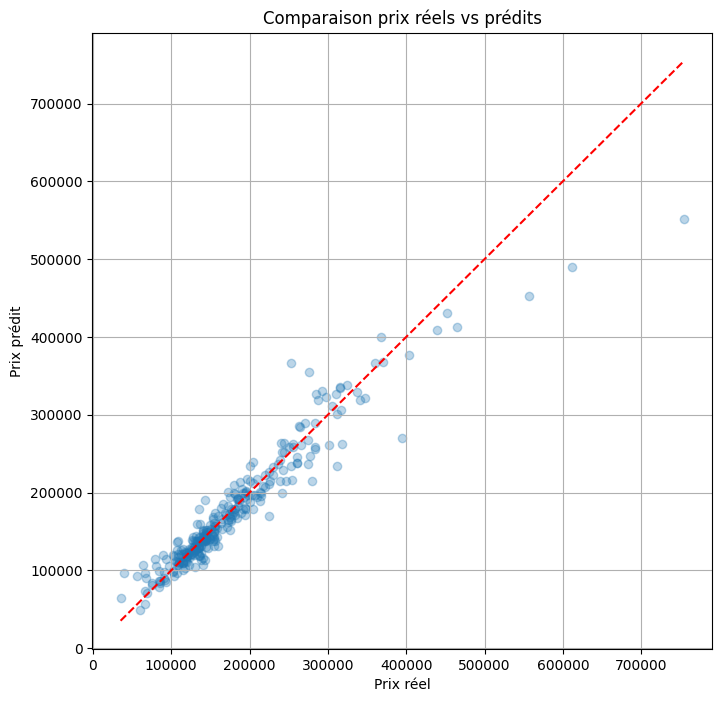

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(y_true_val, y_pred_val, alpha=0.3)
plt.plot([y_true_val.min(), y_true_val.max()],
         [y_true_val.min(), y_true_val.max()],
         'r--')
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title("Comparaison prix réels vs prédits")
plt.grid(True)
plt.show()

# 11. Prédiction test Kaggle

In [11]:
y_test_log = model_pipeline.predict(test)
y_test = np.expm1(y_test_log)

# 12. Export submission

In [12]:
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": y_test
})

submission.to_csv('../data/proced/submissionXGB.csv', index=False)

submission.head()

,Id,SalePrice
0,1461,127904.687500
1,1462,159932.812500
2,1463,185627.765625
3,1464,192094.453125
4,1465,195348.531250
